In [1]:
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['image.aspect'] = 'auto'
matplotlib.rcParams['image.cmap'] = 'gray'
matplotlib.rc('font', weight='normal', size=12)

# Load image

In [2]:
img = cv2.imread('tests/test_img/native_res_skin.png', cv2.IMREAD_GRAYSCALE)
z_spacing = 0.01925
extent = [-19.1955, 19.1955, 19.92375, 0.0]

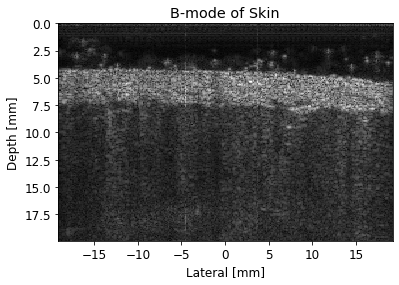

In [3]:
plt.imshow(img, extent=extent)
plt.title('B-mode of Skin')
plt.xlabel('Lateral [mm]')
plt.ylabel('Depth [mm]')
plt.show()

# Thresholding

In [4]:
from thresholding.img_proc import get_otsu, truncate
from thresholding.mask_proc import get_tops, prune_tops, fill_holes

In [5]:
h, w = img.shape
x_range = np.arange(w)

# Detect top edge
otsu = get_otsu(img)
otsu = fill_holes(otsu, mode=1)
x, tops = get_tops(otsu, start_depth=50, end_depth=500)
x, tops = prune_tops(x, tops, degree=3)
p = np.interp(x_range, x, tops)

# Detect bottom edge
trunc_img, trunc_h = truncate(img, np.rint(p).astype(int))
trunc_otsu = get_otsu(trunc_img)
trunc_otsu = fill_holes(trunc_otsu, mode=0)
x, bots = get_tops(np.logical_not(trunc_otsu), start_depth=50, end_depth=500)
x, bots = prune_tops(x, bots, degree=1)
bots += np.take(p, x)
q = np.interp(x_range, x, bots)

In [6]:
# Convert coordinates to millimeters
x = np.linspace(extent[0], extent[1], w)
p *= z_spacing
q *= z_spacing

trunc_extent = extent.copy()
trunc_extent[3] = (1 - trunc_h/h) * extent[2]

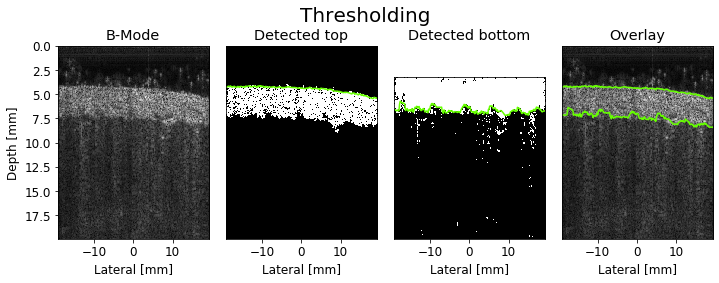

In [7]:
fig = plt.figure(figsize=(10, 4))
gs = fig.add_gridspec(8, 4)

ax0 = fig.add_subplot(gs[1:, 0])
ax0.imshow(img, extent=extent)
ax0.set_xlabel('Lateral [mm]')
ax0.set_ylabel('Depth [mm]')
ax0.set_title('B-Mode')

ax1 = fig.add_subplot(gs[1:, 1])
ax1.imshow(otsu, extent=extent)
ax1.plot(x, p, linewidth=1.5, color='#66FF00')
ax1.set_title("Detected top")
ax1.set_xlabel('Lateral [mm]')
ax1.get_yaxis().set_visible(False)

axtmp = fig.add_subplot(gs[1, 2])
axtmp.set_title("Detected bottom")
axtmp.axis('off')
ax2 = fig.add_subplot(gs[2:, 2])
ax2.imshow(trunc_otsu, extent=trunc_extent)
ax2.plot(x, (q - p) + trunc_extent[3], linewidth=1.5, color='#66FF00')
ax2.set_xlabel('Lateral [mm]')
ax2.get_yaxis().set_visible(False)

ax3 = fig.add_subplot(gs[1:, 3])
ax3.imshow(img, extent=extent)
ax3.plot(x, p, linewidth=1.5, color='#66FF00')
ax3.plot(x, q, linewidth=1.5, color='#66FF00')
ax3.set_xlabel('Lateral [mm]')
ax3.set_title("Overlay")
ax3.get_yaxis().set_visible(False)

fig.tight_layout()
plt.suptitle('Thresholding', fontsize=20)
plt.savefig('imgs/threshold.png', dpi=200)
plt.show()

# Neural Network

In [8]:
import torch
from network.segnet_deploy import load_model, color_log_p

In [9]:
device = 'cpu'
h = img.shape[0] - img.shape[0]%64
w = img.shape[1] - img.shape[1]%4
extent[2] *= h/img.shape[0]

img_torch = torch.from_numpy(img[:h, :w])
img_torch = img_torch.to(device).float()

m = load_model((h, w), device=device)

In [10]:
with torch.no_grad():
    c, p = m(img_torch[None, None])
c = c[0].cpu().numpy()
p = p[0].cpu().numpy()

heatmap = color_log_p(p)
heatmap[:, :8] *= 0
heatmap[:, -8:] *= 0

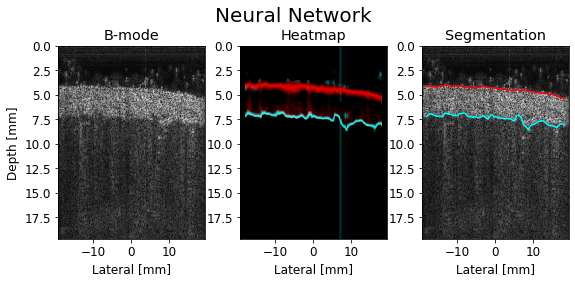

In [11]:
x = np.linspace(extent[0], extent[1], w)

fig = plt.figure(figsize=(8, 4))
gs = fig.add_gridspec(8, 3)

ax0 = fig.add_subplot(gs[1:, 0])
ax0.imshow(img, extent=extent)
ax0.set_xlabel('Lateral [mm]')
ax0.set_ylabel('Depth [mm]')
ax0.set_title('B-mode')

ax1 = fig.add_subplot(gs[1:, 1])
ax1.imshow(heatmap, extent=extent)
ax1.set_xlabel('Lateral [mm]')
ax1.set_title('Heatmap')

ax2 = fig.add_subplot(gs[1:, 2])
ax2.imshow(img, extent=extent)
ax2.plot(x[8:-8], c[0, 8:-8]*h*z_spacing, linewidth=1.5, color='r')
ax2.plot(x[8:-8], c[1, 8:-8]*h*z_spacing, linewidth=1.5, color='cyan')
ax2.set_title('Segmentation')
ax2.set_xlabel('Lateral [mm]')

plt.tight_layout()
plt.suptitle('Neural Network', fontsize=20)
plt.savefig('imgs/network.png', dpi=200)
plt.show()